In [0]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit,GridSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score,make_scorer,classification_report,accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


In [172]:
#Reading train and test data
digits_tra=pd.read_csv('/content/optdigits.tra',sep=",")
print(digits_tra.shape)
X_train,y_train= digits_tra.iloc[:,:-1],digits_tra.iloc[:,-1:]
print(X_train.shape,y_train.shape)

digits_test=pd.read_csv('/content/optdigits.tes',sep=",")
print(digits_test.shape)
X_test,y_test= digits_test.iloc[:,:-1],digits_test.iloc[:,-1:]
print(X_test.shape,y_test.shape)

(3822, 65)
(3822, 64) (3822, 1)
(1796, 65)
(1796, 64) (1796, 1)


In [0]:
#This function is used to determine the variation in cross-validated training and test scores, for different training set sizes
#Here we have used ShuffleSplit as cross-validator
#Basically this cross-validator shuffles and splits the (training dataset) into train and validation, k times(we have set this to 3).
#Thus three splits are generated.
#Then, learning_curve will generate SUBSETS of varying size of the training set and use them to train the classifier.
#So if there are 3 splits, and subset_size is 2, then the above will happen 3 times for subset_size=2. F1-score will be calculated for each training subset and associated test set.
#Finally, the training and testing scores for each training_subset_size will be AVERAGED over the no of splits(3 in our case). 
#These values will be plotted as train and test score(F1) for the given training_subset_size
#Repeat for different training_subset_sizes

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): 
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  scorer = make_scorer(f1_score, average = "weighted")
  train_sizes,train_scores,test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring=scorer)
  
  train_scores_mean=np.mean(train_scores,axis=1)
  train_scores_std=np.std(train_scores,axis=1)
  test_scores_mean=np.mean(test_scores,axis=1)
  test_scores_std=np.std(test_scores,axis=1)
  plt.grid()

  plt.fill_between(train_sizes,train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
  plt.fill_between(train_sizes,test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,color="g")
  plt.plot(train_sizes,train_scores_mean,'o-',color="r",label="Training score")
  plt.plot(train_sizes,test_scores_mean,'o-',color="g",label="Test score")
  plt.legend(loc="best")
  return plt

In [0]:
#This method uses GridSearchCV for hyperparameter tuning. 
#SVM Classifier requires 3 parameters - GAMMA, C and the kernel type. Thre are 4 types of kernels.
#It uses the cross-validator specified by us to find the best value for each parameter.
#The set of possible values for each parameter is passed as a Dictionary by us.

def fit_SVM(kernel,n_jobs,C,gamma):
  classifier = SVC() #Creating a SVM Classifier with specified kernel
  cv = ShuffleSplit(test_size=0.2,random_state=0,n_splits=5)  #Cross-validation strategy, could have used KFold as well
  scorer = make_scorer(f1_score, average = "weighted")
  classifier = GridSearchCV(classifier,cv=cv, param_grid=dict(C=C,gamma=gamma,kernel=kernel),n_jobs=n_jobs,scoring=scorer)
  classifier.fit(X_train,y_train)
  print("Best estimator through GridSearch CV")
  print(classifier.best_estimator_)

  return classifier.best_estimator_.C, classifier.best_estimator_.gamma, classifier.best_estimator_.kernel, cv



In [175]:
#Passing the set of values for each parameter, to be used by GridSearchCV to select the best.
#This impacts the processing time. Cant give a long list
C_vals=[.3, 1, 3]
gamma_vals=[0.001, .003, .01]
kernels=['linear','poly','rbf','sigmoid']
#Getting the best values found for each parameter by GridSearchCV
C, gamma,kernel,cv=fit_SVM(kernels, 10, C_vals, gamma_vals)


Best estimator through GridSearch CV
SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


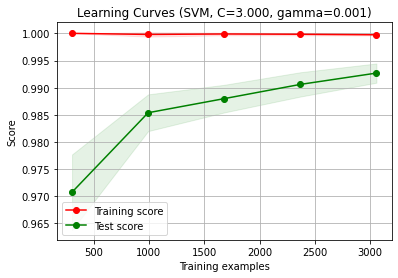

In [176]:
#We create a SVM Classifier with parameters set to values given by Gridsearch
#We plot its learning curve
#It shows how is the F1-score variation as the no of training samples increase
title = "Learning Curves (SVM, C=%.3f, gamma=%.3f)" %(C,gamma) 
classifier = SVC(kernel=kernel, C=C, gamma=gamma)
plot_learning_curve(classifier, title, X_train, y_train, cv=cv)
plt.show() 

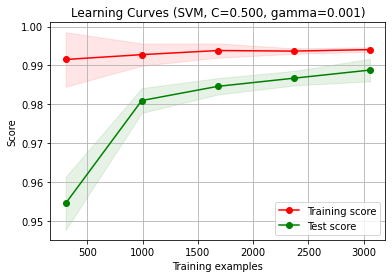

In [177]:
C=0.5
title = "Learning Curves (SVM, C=%.3f, gamma=%.3f)" %(C,gamma) 
classifier = SVC(kernel=kernel, C=C, gamma=gamma)
plot_learning_curve(classifier, title, X_train, y_train, cv=cv)
plt.show() 

In [178]:
#Everything is set now, make predictions
classifier.fit(X_train,y_train)
y_predicted= classifier.predict(X_test)
print(classification_report(y_test,y_predicted,target_names=['0','1','2','3','4','5','6','7','8','9']))
print("Number of correctly classified test samples:",accuracy_score(y_test,y_predicted,normalize=False))
print("Total test samples available:",X_test.shape[0])
print("Overall classification accuracy",(accuracy_score(y_test,y_predicted))*100)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       177
           1       0.96      0.99      0.98       182
           2       1.00      0.98      0.99       177
           3       0.99      0.97      0.98       183
           4       0.99      0.99      0.99       181
           5       0.98      0.99      0.99       182
           6       1.00      0.99      1.00       181
           7       0.99      0.94      0.96       179
           8       0.97      0.94      0.96       174
           9       0.90      0.98      0.94       180

    accuracy                           0.98      1796
   macro avg       0.98      0.98      0.98      1796
weighted avg       0.98      0.98      0.98      1796

Number of correctly classified test samples: 1756
Total test samples available: 1796
Overall classification accuracy 97.7728285077951


Confusion Matrix when classified using SVM Classifier


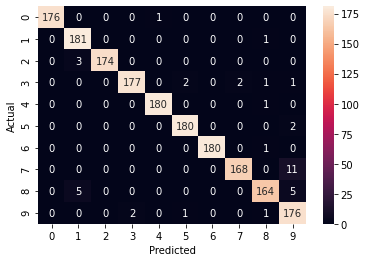

In [179]:
#Performance evaluation- Confusion Matrix
conf_matrix=confusion_matrix(y_test,y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
print('Confusion Matrix when classified using SVM Classifier')

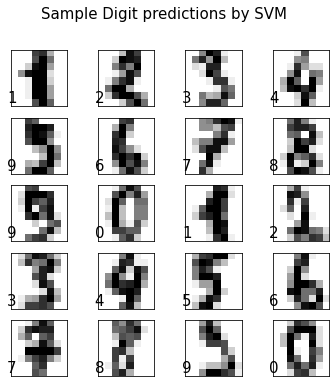

In [180]:
#Seeing the predicted vs actual classes for first twenty samples
fig=plt.figure(figsize=(6,6))
fig.suptitle('Sample Digit predictions by SVM', fontsize=15, alpha=2)
for i in range(20):
   ax=fig.add_subplot(5,4,i+1,xticks=[], yticks=[])
   X_test_image= np.array(X_test.iloc[i,:])
   X_test_image = X_test_image.reshape(8,8)
   ax.imshow(X_test_image.reshape(8,8), cmap=plt.cm.binary)
   ax.text(-1, 7, y_predicted[i].astype(int), fontsize=15, color='black', alpha=2)
plt.show()

In [0]:
#Doing the same as above for LR

def fit_LR(penalty,n_jobs,C,solver):
  classifier = LogisticRegression(multi_class='multinomial') #Creating a SVM Classifier with specified kernel
  cv = ShuffleSplit(test_size=0.2,random_state=0,n_splits=5)  #Cross-validation strategy, could have used KFold as well
  scorer = make_scorer(f1_score, average = "weighted")
  classifier = GridSearchCV(classifier,cv=cv, param_grid=dict(C=C,penalty=penalty,solver=solver),n_jobs=n_jobs,scoring=scorer)
  classifier.fit(X_train,y_train)
  print("Best estimator through GridSearch CV")
  print(classifier.best_estimator_)

  return classifier.best_estimator_.C, classifier.best_estimator_.penalty, classifier.best_estimator_.solver, cv



In [182]:
#Passing the set of values for each parameter, to be used by GridSearchCV to select the best.
#This impacts the processing time. Cant give a long list
C_vals=[.5, 1, 3]
solver=['newton-cg','sag','saga','lbfgs']
penalty=['l1','l2','elasticnet','none']
#Getting the best values found for each parameter by GridSearchCV
C, penalty,solver,cv=fit_LR(penalty, 10, C_vals, solver)


Best estimator through GridSearch CV
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


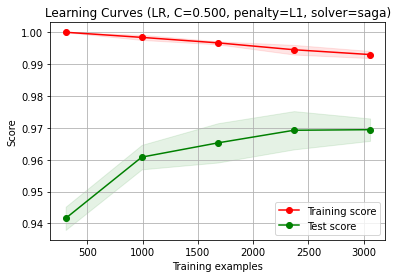

In [188]:
#We create a SVM Classifier with parameters set to values given by Gridsearch
#We plot its learning curve
#It shows how is the F1-score variation as the no of training samples increase
title = "Learning Curves (LR, C=%.3f, penalty=%s, solver=%s)" %(C,'L1','saga') 
classifier = LogisticRegression(penalty=penalty, C=C, solver=solver,multi_class='multinomial')
plot_learning_curve(classifier, title, X_train, y_train, cv=cv)
plt.show() 

In [184]:
#Everything is set now, make predictions
classifier.fit(X_train,y_train)
y_predicted= classifier.predict(X_test)
print(classification_report(y_test,y_predicted,target_names=['0','1','2','3','4','5','6','7','8','9']))
print("Number of correctly classified test samples:",accuracy_score(y_test,y_predicted,normalize=False))
print("Total test samples available:",X_test.shape[0])
print("Overall classification accuracy",(accuracy_score(y_test,y_predicted))*100)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       177
           1       0.92      0.97      0.95       182
           2       0.97      0.97      0.97       177
           3       0.98      0.92      0.95       183
           4       0.97      0.97      0.97       181
           5       0.91      0.97      0.94       182
           6       0.99      0.98      0.98       181
           7       0.99      0.91      0.95       179
           8       0.94      0.91      0.92       174
           9       0.91      0.96      0.93       180

    accuracy                           0.96      1796
   macro avg       0.96      0.96      0.96      1796
weighted avg       0.96      0.96      0.96      1796

Number of correctly classified test samples: 1716
Total test samples available: 1796
Overall classification accuracy 95.54565701559021


Confusion Matrix when classified using LR Classifier


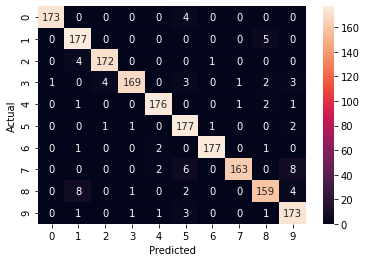

In [186]:
#Performance evaluation- Confusion Matrix
conf_matrix=confusion_matrix(y_test,y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
print('Confusion Matrix when classified using LR Classifier')